# Antarctic Sea Ice Prediction by Chen & Yuan 2004

The starting point for our work is from Chen and Yuan's seminal [paper](https://doi.org/10.1175/1520-0442(2004)017<3156:AMMFSF>2.0.CO;2) in 2004. This paper builds on some of the analysis presented previously in a simpler [model study focussed on ENSO](https://onlinelibrary.wiley.com/doi/epdf/10.1034/j.1600-0870.1994.00013.x). 


The basic premise of this work is that sea ice around Antarctica can be predicted with the help of a linear dynamical model, which is purely driven by data or also called a statistical model (no physics dynamics are provided as input by the researcher). 


This statistical model is setup as a two step process:
- A MEOF analysis. This allows us to tremendously decreases the dimensionality of the system. 
- A linear Markov Model. This allows us to do time series prediction. 


Let's remind ourselves about what the data looks like:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ds_SI = xr.open_zarr('gs://leap-persistent/dhruvbalwada/SI_pred_project/sic_1X0p5.zarr')

In [3]:
ds_SI

<xarray.Dataset>
Dimensions:            (tdim: 516, y: 80, x: 360)
Coordinates:
  * tdim               (tdim) datetime64[ns] 1979-01-01 ... 2021-12-01
  * x                  (x) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * y                  (y) float64 -89.5 -89.0 -88.5 -88.0 ... -51.0 -50.5 -50.0
Data variables:
    sic_anom           (tdim, y, x) float64 dask.array<chunksize=(65, 20, 90), meta=np.ndarray>
    sic_anom_smoothed  (tdim, y, x) float64 dask.array<chunksize=(65, 20, 90), meta=np.ndarray>

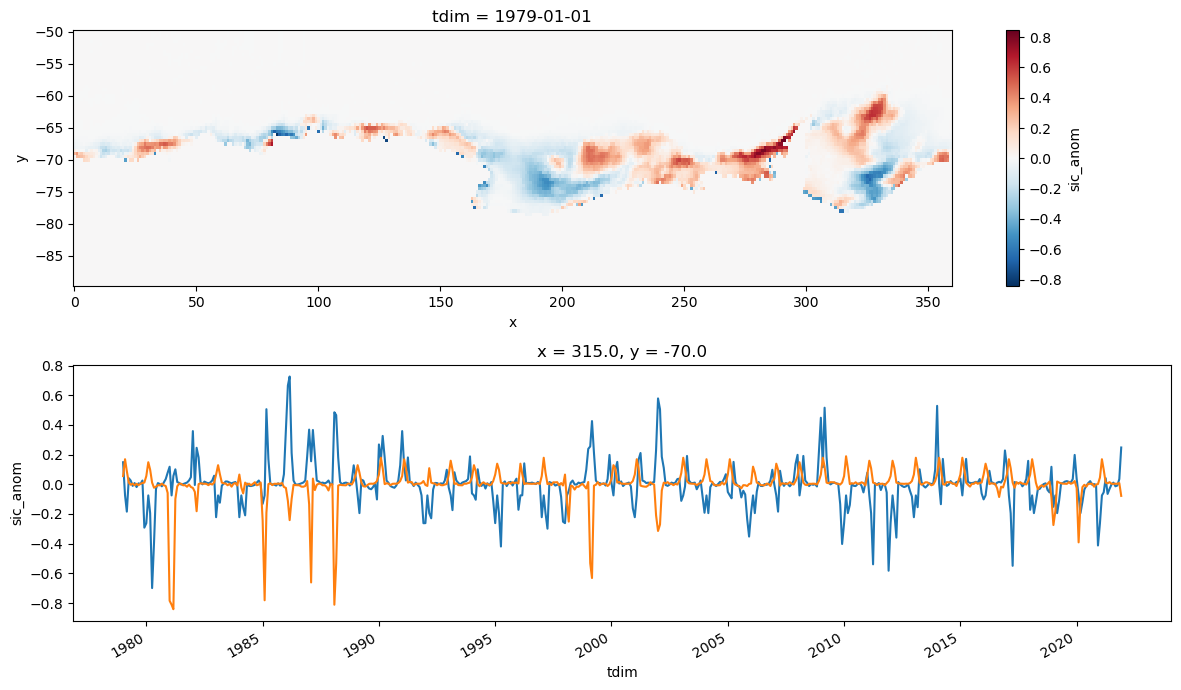

In [4]:
# Make some plots

plt.figure(figsize=(12, 7))
plt.subplot(211)
ds_SI.sic_anom.isel(tdim=0).plot()

plt.subplot(212)
ds_SI.sic_anom.sel(x=200, y=-70, method='nearest').plot(label='Ross sea')
ds_SI.sic_anom.sel(x=315, y=-70, method='nearest').plot(label='Weddell sea')

plt.tight_layout()

In [5]:
# Make some movies
import anim_help

In [6]:
def plot(idT=-1):
    # Just copied code from above cell to help make an animation

    plt.figure(figsize=(12, 7))
    plt.subplot(211)
    ds_SI.sic_anom.isel(tdim=idT).plot(vmin=-0.8)

    plt.subplot(212)
    ds_SI.sic_anom.sel(x=200, y=-70, method='nearest').plot(label='Ross sea')
    ds_SI.sic_anom.sel(x=315, y=-70, method='nearest').plot(label='Weddell sea')
    plt.legend()
    plt.vlines(ds_SI.tdim.isel(tdim=idT), -0.8, 0.8, color='k', linestyle='--')
    
    plt.tight_layout()

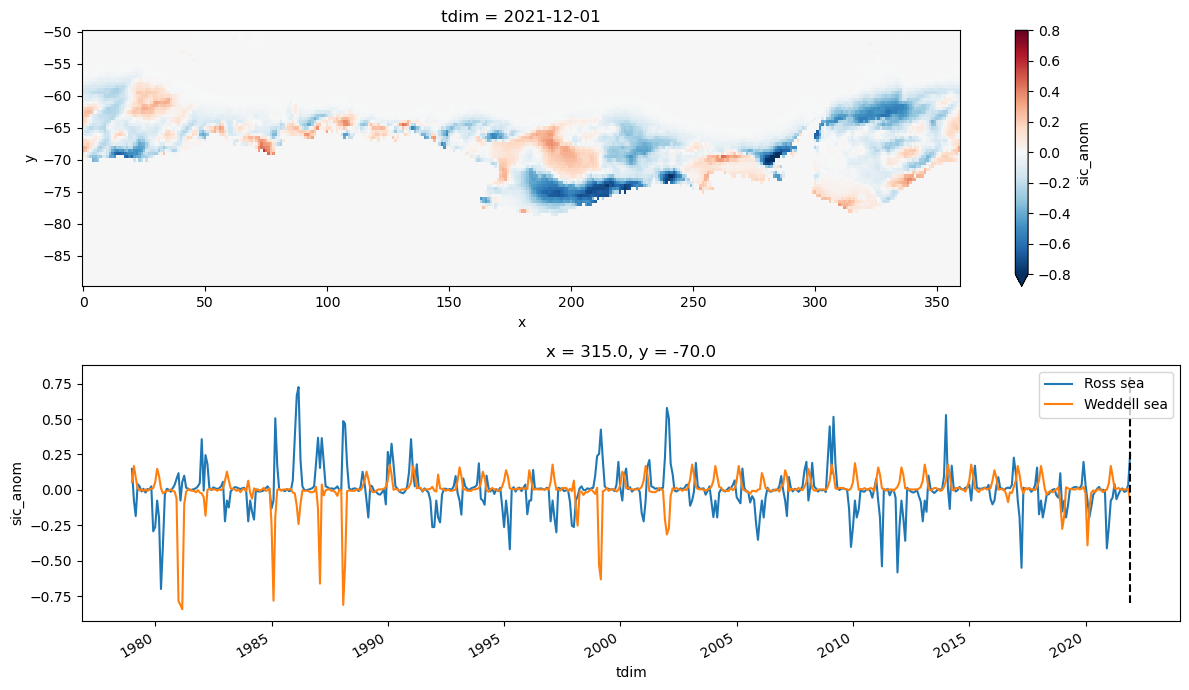

In [7]:
plot()

In [8]:
flag_movie = 0 # set to 1 if you want to recreate the movie.
if flag_movie == 1:
    anim_help.create_animation(plot, range(0, 516), 'SI_anomaly.gif', dpi=100)

### Dimensionality Reduction

The datasets that we are using (e.g. SIC) has a lot of points of measurements, 360X80 (=28800) points in space and 516 months in time. However, when we look at the pattern of SIC at any time we see that it appears almost like a few blobs on a map, rather than 20K+ completely independently varying points. Noticing this fact allows us to realize that maybe we don't need so many points to represent our data, and probably many fewer points will do. 

As a simpler example think about the sine wave
$$
sin(kx + \theta) 
$$

In [9]:
import numpy as np

In [10]:
x = np.linspace(0, 2*np.pi, 100)

def sin(x, k=1, phi=0):
     return np.sin(k*x + phi)

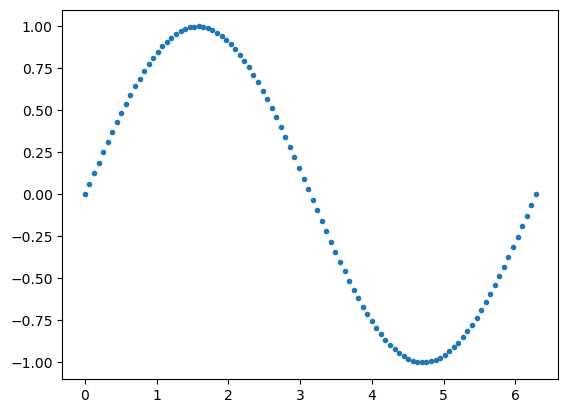

In [11]:
plt.plot(x, sin(x), '.')

Now we know that if we were to change the phase, the only thing that changes is the location in space for the wave. 

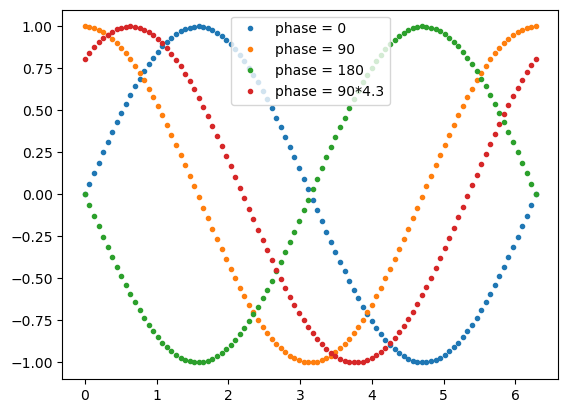

In [12]:
plt.plot(x, sin(x), '.', label='phase = 0')
plt.plot(x, sin(x,phi=np.pi/2), '.', label='phase = 90')
plt.plot(x, sin(x,phi=np.pi), '.', label='phase = 180')
plt.plot(x, sin(x,phi=np.pi*4.3), '.', label='phase = 90*4.3')
plt.legend()

This makes us wonder whether we can write down this signal (100points) as a combination of few shapes (the sine wave or cosine wave) multiplied by a few numbers that tell us about where in space the waves are located. This is what dimensionality reduction does. 

We know that this may be mathematically possible as we know the relationship:

$$
sin(kx + \theta) = sin(kx) cos(\theta) + cos(kx) sin(\theta),
$$
which suggests that any arbitrary sine wave can be written as a combination of 2 patterns (sinkx and coskx) multiplied by 2 numbers. 

Let's see how this works with an example where the phase changes in time. 

In [13]:
T = np.linspace(0, 51, 51)

phi = T*0.5

data = np.zeros((len(x), len(T)))
for i, phase in enumerate(phi):
    data[:, i] = sin(x, phi=phase)


In [14]:
da = xr.DataArray(data, dims=['x','time'], coords={'x':x, 'time':T})

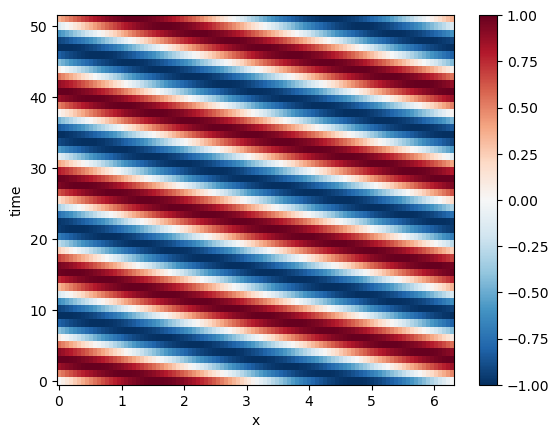

In [15]:
da.plot(x='x')

Let's apply an EOF analysis to see if we recover what we expect. 

In [16]:
from eofs.xarray import Eof

In [17]:
solver = Eof(da.transpose('time','x'))
# This function expects time as the first input.

In [18]:
eofs= solver.eofs()
eigenvalues = solver.eigenvalues()
pcs = solver.pcs()

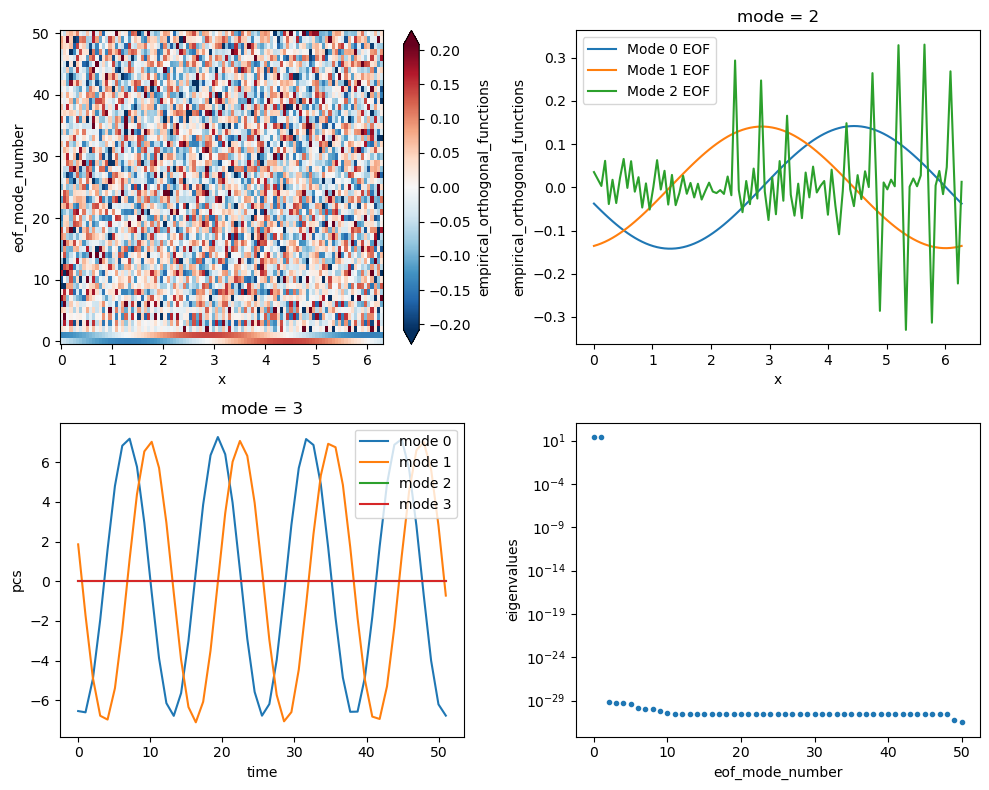

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
eofs.plot(robust=True)

plt.subplot(222)
eofs.isel(mode=0).plot(label='Mode 0 EOF')
eofs.isel(mode=1).plot(label='Mode 1 EOF')
eofs.isel(mode=2).plot(label='Mode 2 EOF')
plt.legend()

plt.subplot(223)
pcs.isel(mode=0).plot(label='mode 0')
pcs.isel(mode=1).plot(label='mode 1')
pcs.isel(mode=2).plot(label='mode 2')
pcs.isel(mode=3).plot(label='mode 3')
plt.legend()

plt.subplot(224)
eigenvalues.plot.line('.')
plt.yscale('log')

plt.tight_layout()

Notice above,  
- Except the first 2 modes all the modes (patterns) look like noise. These first 2 modes are sin(kx) and cos(kx). The other modes are noise, but this won't matter as their corresponding PC time series will be negligible. 
- The pcs looks like waves that change in time (these should be cos(theta) and sin(theta). At each time the PCs multiply the pattern to give you the structure. Since all the PCs, except the first two, are zero, this implies that we only need 2 numbers to represent all our data. 
- The eigen values which tell you how informaiton is captured by each mode also show us this. Notice that except the first 2 values all others are basically 0. 

Obviously the above example was a very easy one, where we didn't even need to use EOF analysis as we understood our data and its structure well. 
However, you should be able to see the power of this technique - 100 points of information reduced to 2. Such methods (there are many others) can help us analyze our data sets. 

**Exercise 1**: Apply the above technique to a problem with 2 spatial dimensions and 1 time dimension. Use simple sine or cosine functions (or some other simple math function of your choice) to create the patterns and see if EOF analysis can recover these for you. 

**Exercise 2**: Linear autoencoders are considered to be equivalent to EOFs. Could you show how you might use an auto encoder to solve our problem here? 

**Exercise 3**: Can you create datasets that have non-linearity (maybe imagine that the the wavenumber - k - for the sine wave changed in time too)? What do the results from EOF analysis look like for this data? Can some non-linear dimensionality reduction techniques help you with this and do better than plain EOF?

**Exercise 4**: Apply the EOF analysis to the SIC dataset and see what the modes (spatial patterns) look like. What is the temporal evolution of these modes? How many modes do you need to represent most of your data's variability?
 
**Exercise 5**: Can you make the above task most sophisitcated (less modes explain more) by using some other method (other than EOF)?

**Exercise 6**: How would one go about expanding this analysis to multiple variables, which co-vary? (How do MEOFs work?)

Further reading:
- Dimensionality reduction baics: https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Intro.html 
- Autoencoders: https://compneuro.neuromatch.io/tutorials/Bonus_Autoencoders/student/Bonus_Intro.html

### Linear Dynamics and Markov Chains

CY2004 does the time series prediction by building an AR1 process. This is a linear dynamics system where the state at each time only depends on the time before it:
$$
\mathbf{X}_{t+1} = \mathbf{A} \mathbf{X}_{t} + \mathbf{\eta}
$$

Where $\mathbf{X}_t={X_t^1, X_t^2, X_t^3, ..}$ can be a vector state at time t. In CY2004 this was the collection of PCs (so maybe 15 numbers if we choose 15 modes). 

We can determine A using some optimization procedure. The simplest and most used one is least-squares method. This is what is used in CY2004, where they use the "normal method" to solve the system. This involves inverting a large matrix (which gets larger as your dataset gets larger), and can be very expensive. 

For very large systems there might be other optimization methods, like using gradient descent (stochastic ADAM etc). Sometimes people also use methods like MLE when they want to get probabilistic estimates of the parameters. 

#### Generate time series data using simple model. 
Here we use an AR1 model to generate our data. This is the best case scenario as the data we are trying to fit comes from the same model, which is not going to be true for most real world applications (where we don't know what the underling dynamics/model is).

In [20]:
X = np.array([[1.5, 2.1]]) # we use a 2 state system
X = X.reshape((2,1))

dt = 0.05
A = np.array([[1 , -dt],[dt, 1]]) # I am just making something random up here.
A

array([[ 1.  , -0.05],
       [ 0.05,  1.  ]])

In [21]:
np.matmul(A, X)

array([[1.395],
       [2.175]])

The above A was chosen to solve a system 
$$
dx/dt = - y
$$
$$
dy/dt = x
$$
where the state vector $\mathbf{X} = (x,y)$. 

Also the Euler time stepping was chosen:

$$
dx/dt = (X_{t+1} - X_{t})/ \triangle t
$$


In [22]:
Tsteps = 1000

for i in range(Tsteps):
    X = np.append(X, np.matmul(A, X[:,-1]).reshape((2,1)), axis=1)

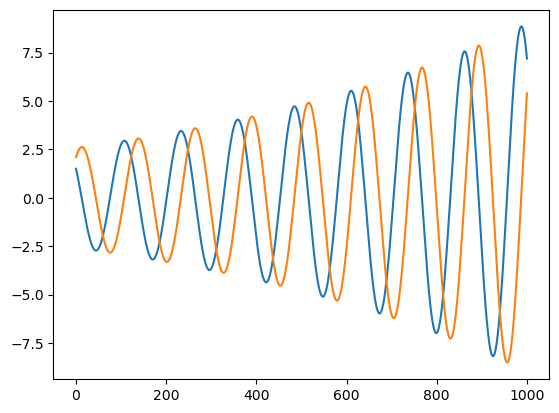

In [23]:
plt.plot(X[0,:])
plt.plot(X[1,:])
#plt.yscale('log')

#### Fit this data using an AR-1 process.

Before we try and fit anything, let us check if there is a relationship. 

In [24]:
x_t1 = X[0,1:] # this is X_t+1
x_t0 = X[0,:-1] # This is X_t

y_t1 = X[1,1:] # ..
y_t0 = X[1,:-1]

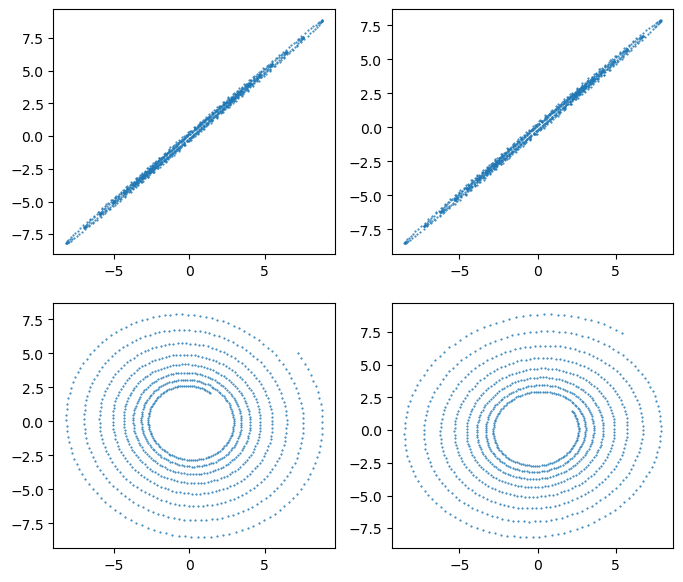

In [25]:
plt.figure(figsize=(8,7))

plt.subplot(221)
plt.plot(x_t1, x_t0, '.', markersize=1)

plt.subplot(222)
plt.plot(y_t1, y_t0, '.', markersize=1)


plt.subplot(223)
plt.plot(x_t1, y_t0, '.', markersize=1)

plt.subplot(224)
plt.plot(y_t1, x_t0, '.', markersize=1)


There is clearly some relationship between the current and future times. However, it is not clear if all the relationships are linear or not from the visuals. Thus visual inspection can sometimes lead us astray, and sometimes it can work well.  

In [26]:
X_t0 = np.stack( (x_t0, y_t0), axis=1).T # we transpose to make the shapes right later
X_t1 = np.stack( (x_t1, y_t1), axis=1).T
X_t0.shape, X_t1.shape

((2, 1000), (2, 1000))

In [27]:
A_est = np.matmul(np.matmul(X_t1, X_t0.T) , np.linalg.inv(np.matmul(X_t0, X_t0.T)))
# this is the formula in equation 4 from CY2004. 

In [28]:
print('estimated A: \n', A_est)
print('true A: \n', A)

estimated A: 
 [[ 1.   -0.05]
 [ 0.05  1.  ]]
true A: 
 [[ 1.   -0.05]
 [ 0.05  1.  ]]


We managed to estimate A correctly in this system.

**Exercise 1:** In the above example we made a linear system to generate time series data and then tried to fit it using a linear model. Expand this to working with cases where the data is generated from a non-linear model (e.g. model in equation 7 from https://arxiv.org/pdf/2202.07022.pdf). 
**Exercise 2:** For the non-linear model try out a range of time series models: AR2 process, RNNs, LSTMs etc. 

#### Side notes about Linear system etc.:

Time series prediction and modeling is a very rich field, and like all rich fields it is rich with jargon. I personally found it much harder to penetrate this (compared to dimensionality reduction), and spent lot of time googling and chatting with chatGPT (see [summary](https://chat.openai.com/share/e73924a2-b224-4c98-a51c-0760d535994f) where I started with some obscure question and realized that I was lacking some basic understanding). 

Some other chat sessions are here: 
- https://chat.openai.com/share/db1e39c2-28d8-4973-b49b-a6f6db520811 (differences between a few time series prediction methods).
- https://chat.openai.com/share/27986c70-fabd-4d1c-8c56-d79319b84ec2 (confusion between AR and markov chain)

I also found some material that looked quite useful:
- https://ericmjl.github.io/essays-on-data-science/machine-learning/markov-models/ (nice intro to Markov stuff).
- https://cs.brown.edu/media/filer_public/44/a6/44a6e5fc-6b95-4b82-b4f5-2b9d55bd53f8/gbarayor.pdf (thinks about Markov models and linear dynamics together). 
- Chapter 13 here: https://cedar.buffalo.edu/~srihari/CSE574/ (some slides going over variety of topics, at the very least gets you familiar with some jargon).
- https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/chapter_title.html (Some tutorial on linear systems and stochastic systems). This chapter builds how you go from dynamical equation, to discrete process, add randomness, have both deterministic and random behavior, and finally how you solve for the dynamical part. This is in essence what the Chen and Yuan 2004 paper do for their work, where they solve the system using the Least-squares normal method (https://compneuro.neuromatch.io/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial1.html#section-2-least-squares-optimization). Their model can also be viewed as auto-regressive (https://compneuro.neuromatch.io/tutorials/W2D2_LinearSystems/student/W2D2_Tutorial4.html#video-1-autoregressive-models).
- Here is another example: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
- Reading the Bayesian Decisions and Hidden dynamics sections from the Stochastic Processes section can also be very helpful. E.g. this: https://compneuro.neuromatch.io/tutorials/W3D2_HiddenDynamics/student/W3D2_Tutorial4.html 
- https://arxiv.org/pdf/2202.07022.pdf Interesting paper on using RNNs with Lorenz 96.
- Within the autoregressive models (like the one time step AR in Chen and Yuan 2004), there is a lot of variations and models with names like AR, MA, ARMA, ARIMA etc show up https://towardsdatascience.com/time-series-models-d9266f8ac7b0. 

Finally [here](https://chat.openai.com/share/db1e39c2-28d8-4973-b49b-a6f6db520811) is me asking chatGPT about how to help develop a simple test bed for this.

## Summary: 

In this notebook we explored the very basics of the two steps that are essential to the CY2004 method: dimensionality reduction and estimating parameters of an AR1 process. Hopefully this was helpful in developing in some intuition. 